## Experiment 3: Real world dataset/application


SVD vs Randomized SVD Results
     k          method   runtime      ssim       psnr
0    3       Exact SVD  0.115091  0.996177  62.908098
1    3  Randomized SVD  0.010957  0.996177  62.908098
2    5       Exact SVD  0.099216  0.997440  64.319547
3    5  Randomized SVD  0.015326  0.997440  64.319547
4    8       Exact SVD  0.103501  0.998536  66.173484
5    8  Randomized SVD  0.019627  0.998536  66.173484
6   10       Exact SVD  0.099728  0.998932  67.159168
7   10  Randomized SVD  0.020193  0.998932  67.159168
8   15       Exact SVD  0.100332  0.999417  68.946858
9   15  Randomized SVD  0.024437  0.999417  68.946858
10  20       Exact SVD  0.101087  0.999641  70.252720
11  20  Randomized SVD  0.029438  0.999641  70.252717


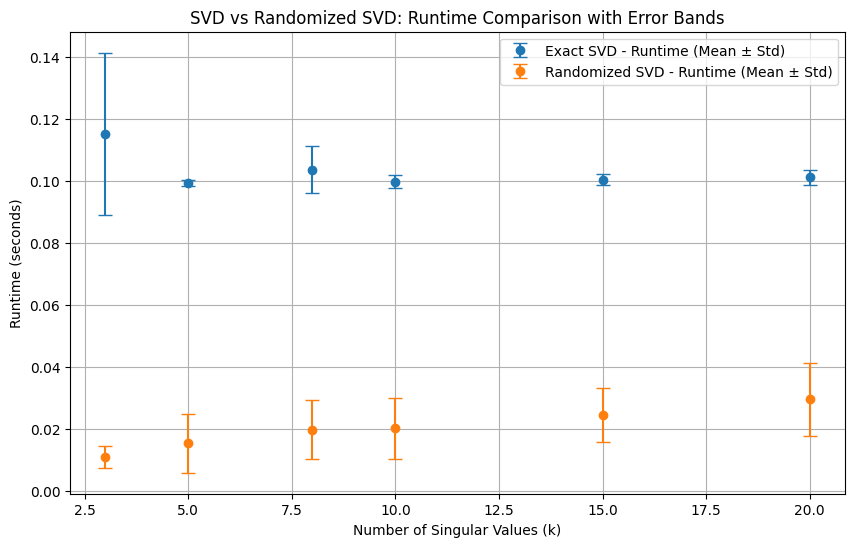

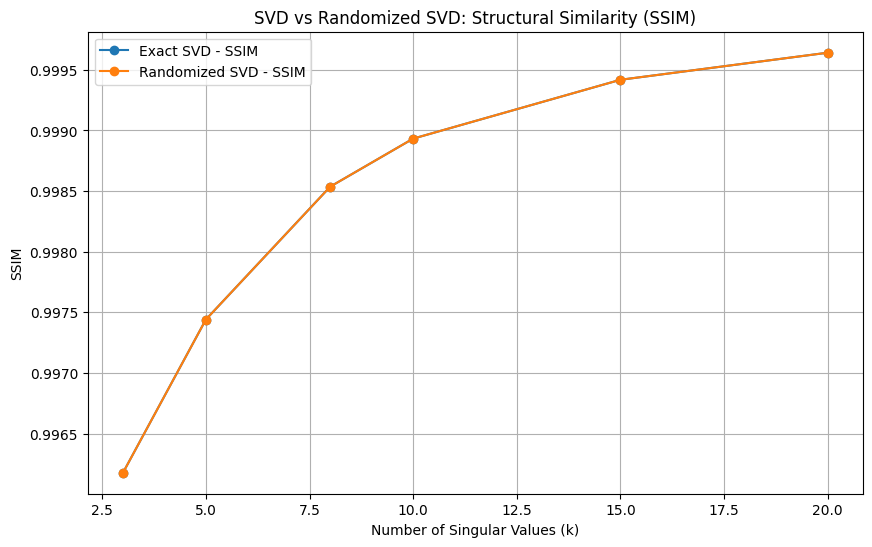

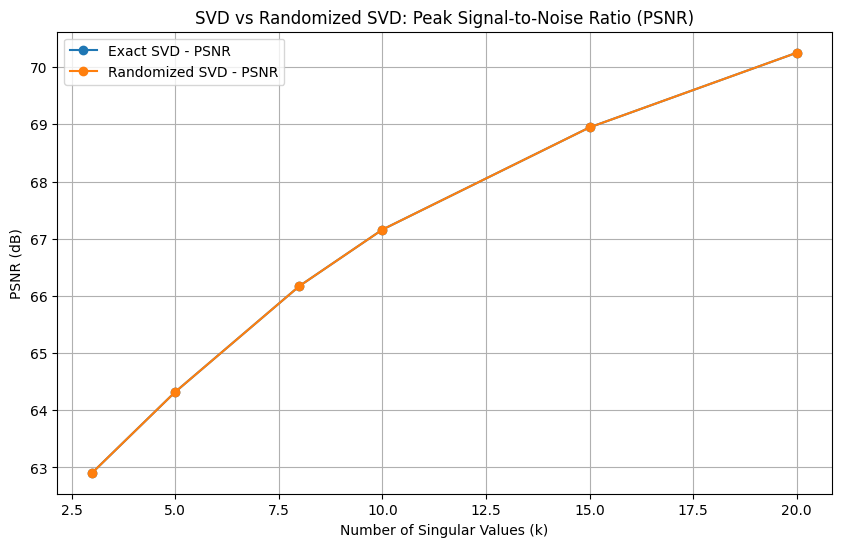

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import time

# Load and preprocess the image (grayscale)
image = rgb2gray(data.astronaut())
image = image / 255.0  # Normalize pixel values to [0, 1]

# Function to compress image using Exact SVD
def compress_svd(image, k):
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    compressed_image = np.dot(U_k, np.dot(S_k, Vt_k))
    return compressed_image

# Function to compress image using Randomized SVD
def compress_randomized_svd(image, k):
    U, S, Vt = randomized_svd(image, n_components=k, random_state=42)
    S_k = np.diag(S)
    compressed_image = np.dot(U, np.dot(S_k, Vt))
    return compressed_image

# Function to calculate PSNR
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # Perfect match
        return float('inf')
    pixel_max = 1.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

# Parameters for comparison
k_values = [3, 5, 8, 10, 15, 20]  # Number of singular values to retain
num_repeats = 5  # Number of repetitions for both SVD methods

# Store results
results = {"k": [], "method": [], "runtime": [], "ssim": [], "psnr": []}
exact_svd_runtimes = {"k": [], "mean_runtime": [], "std_runtime": []}
rsvd_runtimes = {"k": [], "mean_runtime": [], "std_runtime": []}

# Comparison loop
for k in k_values:
    # Exact SVD (repeat 5 times)
    exact_runtimes = []
    for _ in range(num_repeats):
        start_time = time.time()
        svd_image = compress_svd(image, k)
        runtime = time.time() - start_time
        exact_runtimes.append(runtime)
    exact_mean_runtime = np.mean(exact_runtimes)
    exact_std_runtime = np.std(exact_runtimes)
    svd_ssim = ssim(image, svd_image, data_range=1.0)
    svd_psnr = psnr(image, svd_image)

    results["k"].append(k)
    results["method"].append("Exact SVD")
    results["runtime"].append(exact_mean_runtime)
    results["ssim"].append(svd_ssim)
    results["psnr"].append(svd_psnr)

    exact_svd_runtimes["k"].append(k)
    exact_svd_runtimes["mean_runtime"].append(exact_mean_runtime)
    exact_svd_runtimes["std_runtime"].append(exact_std_runtime)

    # Randomized SVD (repeat 5 times)
    rsvd_runtimes_list = []
    for _ in range(num_repeats):
        start_time = time.time()
        rsvd_image = compress_randomized_svd(image, k)
        runtime = time.time() - start_time
        rsvd_runtimes_list.append(runtime)
    rsvd_mean_runtime = np.mean(rsvd_runtimes_list)
    rsvd_std_runtime = np.std(rsvd_runtimes_list)
    rsvd_ssim = ssim(image, rsvd_image, data_range=1.0)
    rsvd_psnr = psnr(image, rsvd_image)

    results["k"].append(k)
    results["method"].append("Randomized SVD")
    results["runtime"].append(rsvd_mean_runtime)
    results["ssim"].append(rsvd_ssim)
    results["psnr"].append(rsvd_psnr)

    rsvd_runtimes["k"].append(k)
    rsvd_runtimes["mean_runtime"].append(rsvd_mean_runtime)
    rsvd_runtimes["std_runtime"].append(rsvd_std_runtime)

# Convert results to a DataFrame and print
df = pd.DataFrame(results)
print("\nSVD vs Randomized SVD Results")
print(df)

# Plot runtime with error bands
plt.figure(figsize=(10, 6))
plt.errorbar(
    exact_svd_runtimes["k"],
    exact_svd_runtimes["mean_runtime"],
    yerr=exact_svd_runtimes["std_runtime"],
    label="Exact SVD - Runtime (Mean ± Std)",
    fmt="o",
    capsize=5,
)
plt.errorbar(
    rsvd_runtimes["k"],
    rsvd_runtimes["mean_runtime"],
    yerr=rsvd_runtimes["std_runtime"],
    label="Randomized SVD - Runtime (Mean ± Std)",
    fmt="o",
    capsize=5,
)
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("Runtime (seconds)")
plt.title("SVD vs Randomized SVD: Runtime Comparison with Error Bands")
plt.legend()
plt.grid()
plt.show()

# Plot SSIM
plt.figure(figsize=(10, 6))
for method in ["Exact SVD", "Randomized SVD"]:
    subset = df[df["method"] == method]
    plt.plot(subset["k"], subset["ssim"], label=f"{method} - SSIM", marker="o")
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("SSIM")
plt.title("SVD vs Randomized SVD: Structural Similarity (SSIM)")
plt.legend()
plt.grid()
plt.show()

# Plot PSNR
plt.figure(figsize=(10, 6))
for method in ["Exact SVD", "Randomized SVD"]:
    subset = df[df["method"] == method]
    plt.plot(subset["k"], subset["psnr"], label=f"{method} - PSNR", marker="o")
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("PSNR (dB)")
plt.title("SVD vs Randomized SVD: Peak Signal-to-Noise Ratio (PSNR)")
plt.legend()
plt.grid()
plt.show()


Processing image: Astronaut

Results for Astronaut
     k          method   runtime      ssim       psnr
0   10       Exact SVD  0.109753  0.998932  67.159168
1   10  Randomized SVD  0.020016  0.998932  67.159168
2   20       Exact SVD  0.109386  0.999641  70.252720
3   20  Randomized SVD  0.030767  0.999641  70.252717
4   50       Exact SVD  0.101339  0.999947  75.480495
5   50  Randomized SVD  0.107650  0.999947  75.480298
6  100       Exact SVD  0.103959  0.999990  81.016510
7  100  Randomized SVD  0.095480  0.999990  81.001375


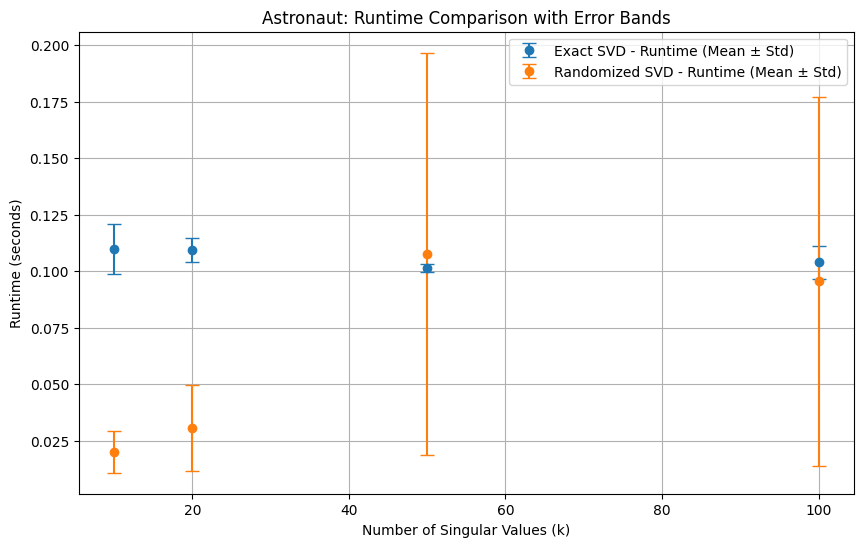

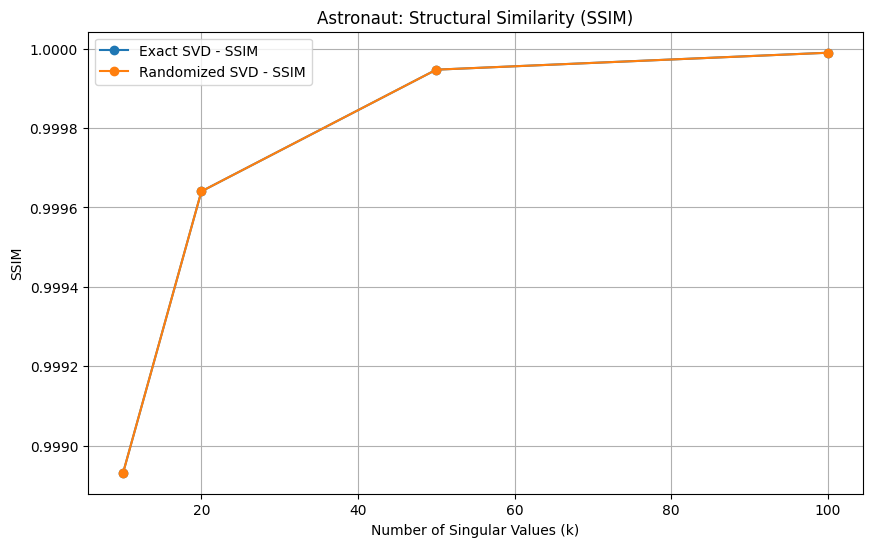

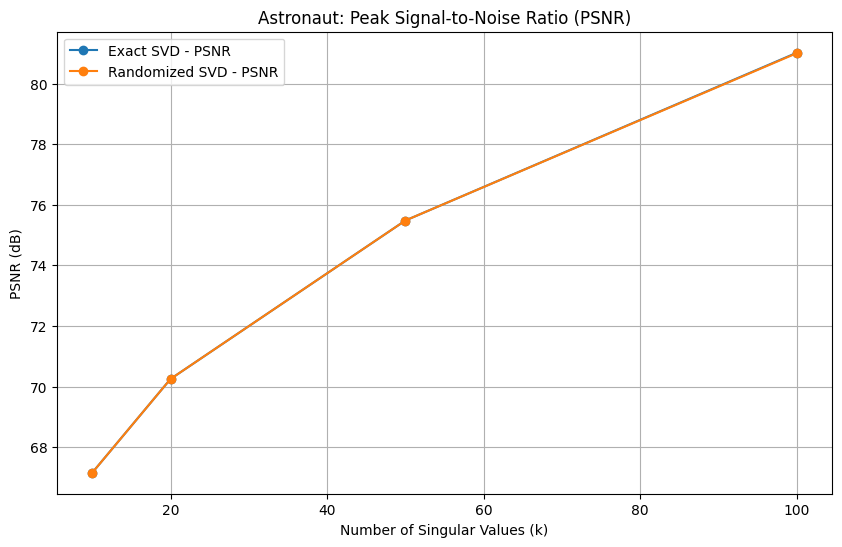

Processing image: Camera

Results for Camera
     k          method   runtime      ssim       psnr
0   10       Exact SVD  0.107362  0.589825  22.082488
1   10  Randomized SVD  0.058926  0.589825  22.082488
2   20       Exact SVD  0.120192  0.649619  24.586491
3   20  Randomized SVD  0.034748  0.649615  24.586490
4   50       Exact SVD  0.102109  0.776201  28.626353
5   50  Randomized SVD  0.033794  0.776060  28.625000
6  100       Exact SVD  0.100762  0.884838  32.796552
7  100  Randomized SVD  0.070392  0.884674  32.775372


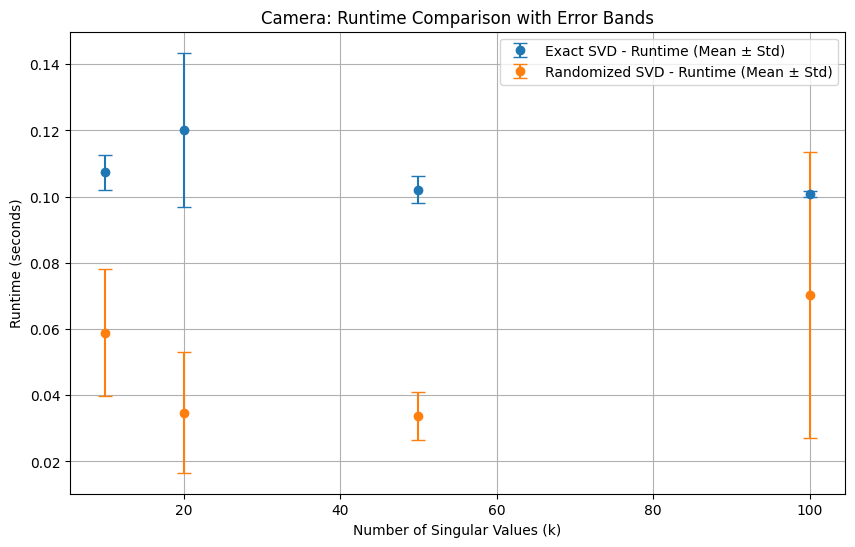

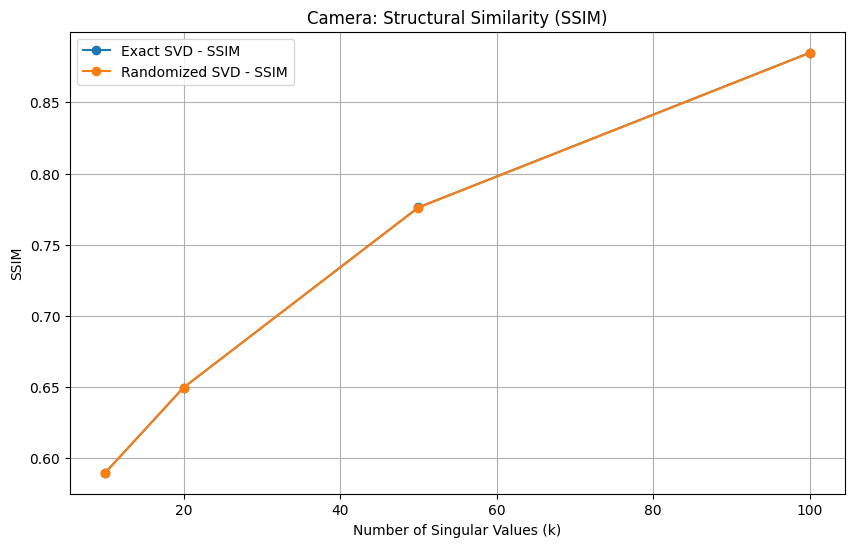

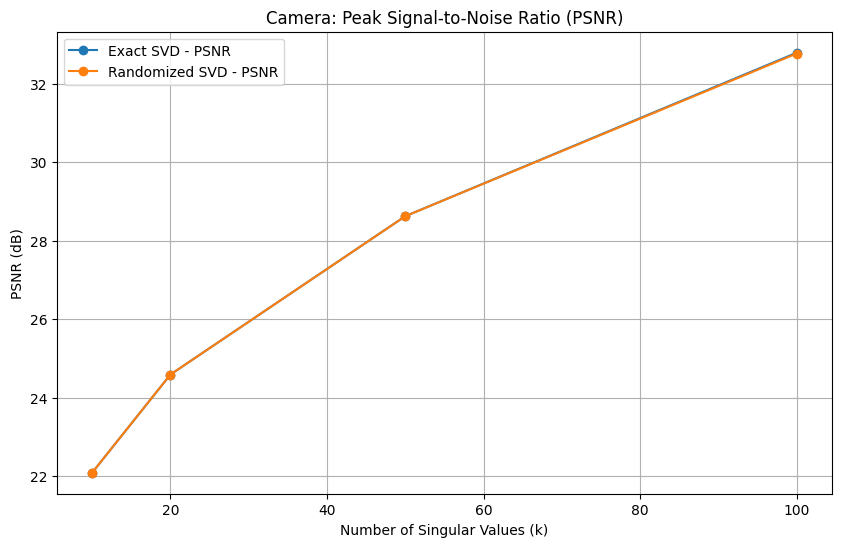

Processing image: Coins

Results for Coins
     k          method   runtime      ssim       psnr
0   10       Exact SVD  0.038508  0.554434  21.652758
1   10  Randomized SVD  0.012855  0.554434  21.652758
2   20       Exact SVD  0.042430  0.641685  23.928480
3   20  Randomized SVD  0.188617  0.641706  23.928446
4   50       Exact SVD  0.040299  0.798813  28.432586
5   50  Randomized SVD  0.044952  0.798803  28.426868
6  100       Exact SVD  0.041159  0.911037  33.861505
7  100  Randomized SVD  0.115867  0.910770  33.848361


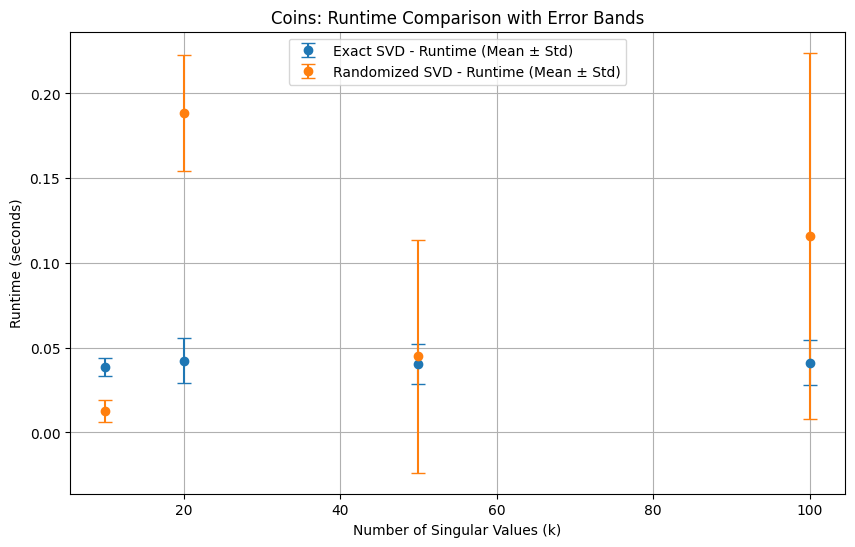

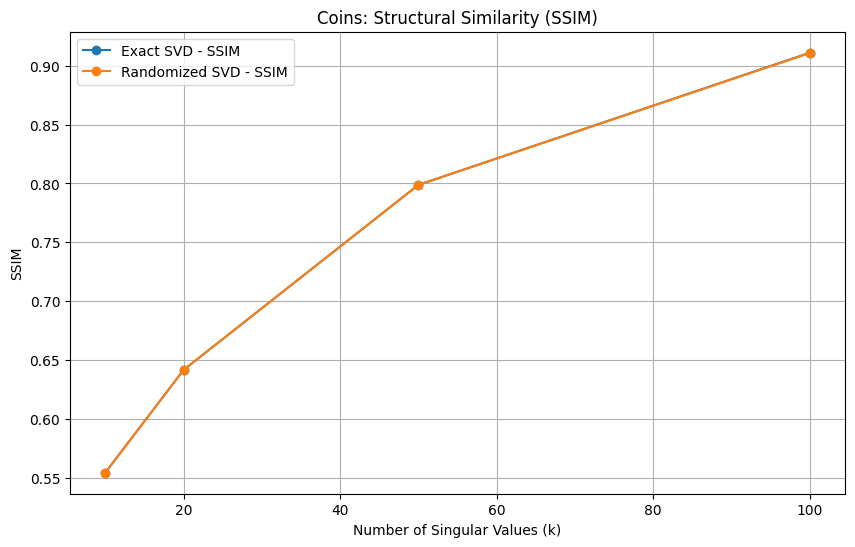

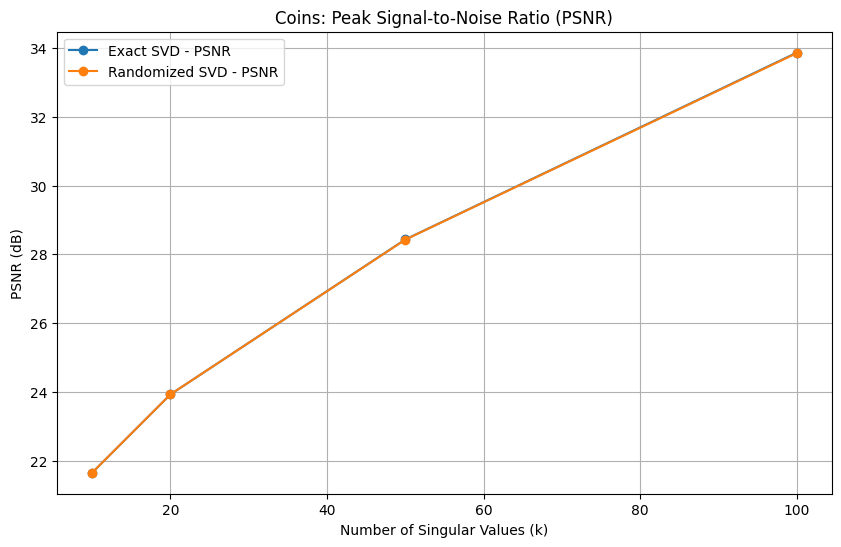

Processing image: Moon

Results for Moon
     k          method   runtime      ssim       psnr
0   10       Exact SVD  0.071366  0.892556  34.269486
1   10  Randomized SVD  0.018059  0.892556  34.269486
2   20       Exact SVD  0.071279  0.914683  36.921032
3   20  Randomized SVD  0.027169  0.914680  36.921027
4   50       Exact SVD  0.070077  0.953664  41.407848
5   50  Randomized SVD  0.196523  0.953663  41.407446
6  100       Exact SVD  0.092498  0.983865  46.974067
7  100  Randomized SVD  0.041548  0.983782  46.947271


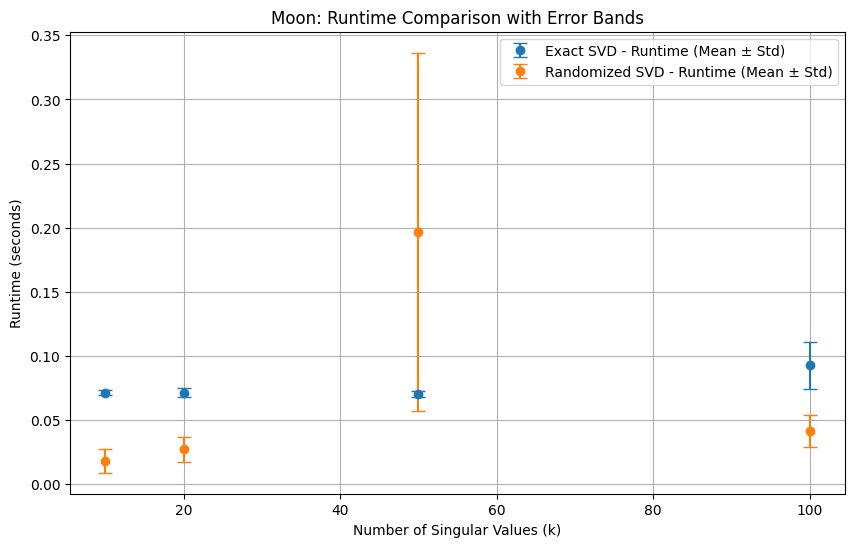

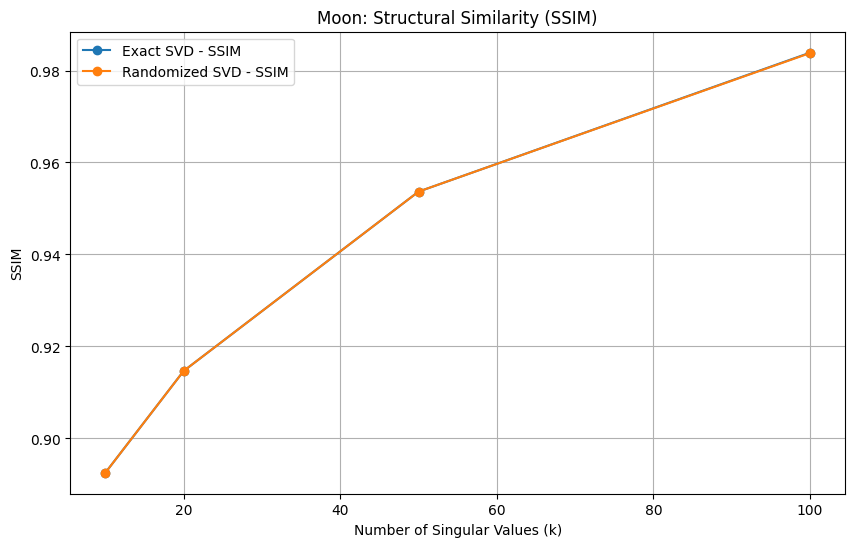

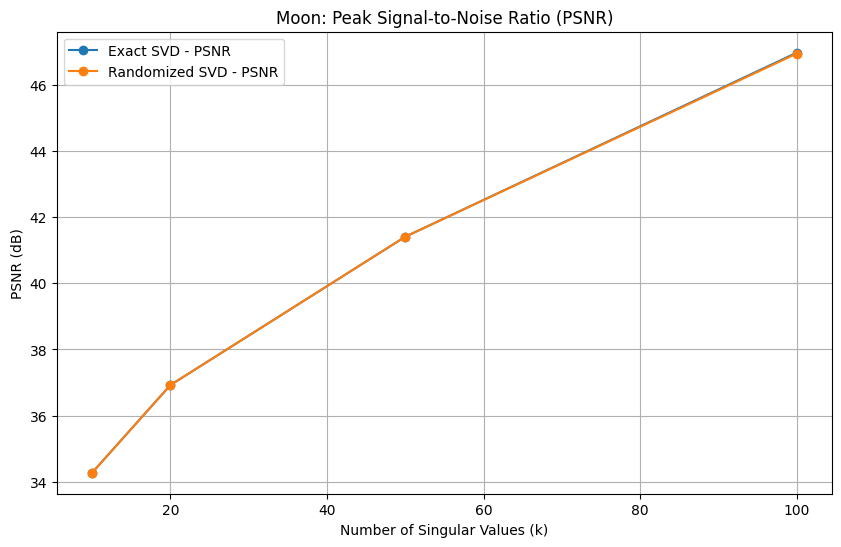

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import time

# List of images to test
images = {
    "Astronaut": rgb2gray(data.astronaut()),
    "Camera": data.camera(),
    "Coins": data.coins(),
    "Moon": data.moon(),
}

# Normalize images to [0, 1]
images = {name: img / 255.0 for name, img in images.items()}

# Function to compress image using Exact SVD
def compress_svd(image, k):
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    compressed_image = np.dot(U_k, np.dot(S_k, Vt_k))
    return compressed_image

# Function to compress image using Randomized SVD
def compress_randomized_svd(image, k):
    U, S, Vt = randomized_svd(image, n_components=k, random_state=42)
    S_k = np.diag(S)
    compressed_image = np.dot(U, np.dot(S_k, Vt))
    return compressed_image

# Function to calculate PSNR
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # Perfect match
        return float('inf')
    pixel_max = 1.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

# Parameters for comparison
k_values = [10, 20, 50, 100]  # Number of singular values to retain
num_repeats = 5  # Number of repetitions for both SVD methods

# Process each image
for image_name, image in images.items():
    print(f"Processing image: {image_name}")
    results = {"k": [], "method": [], "runtime": [], "ssim": [], "psnr": []}
    exact_svd_runtimes = {"k": [], "mean_runtime": [], "std_runtime": []}
    rsvd_runtimes = {"k": [], "mean_runtime": [], "std_runtime": []}

    for k in k_values:
        # Exact SVD (repeat 5 times)
        exact_runtimes = []
        for _ in range(num_repeats):
            start_time = time.time()
            svd_image = compress_svd(image, k)
            runtime = time.time() - start_time
            exact_runtimes.append(runtime)
        exact_mean_runtime = np.mean(exact_runtimes)
        exact_std_runtime = np.std(exact_runtimes)
        svd_ssim = ssim(image, svd_image, data_range=1.0)
        svd_psnr = psnr(image, svd_image)

        results["k"].append(k)
        results["method"].append("Exact SVD")
        results["runtime"].append(exact_mean_runtime)
        results["ssim"].append(svd_ssim)
        results["psnr"].append(svd_psnr)

        exact_svd_runtimes["k"].append(k)
        exact_svd_runtimes["mean_runtime"].append(exact_mean_runtime)
        exact_svd_runtimes["std_runtime"].append(exact_std_runtime)

        # Randomized SVD (repeat 5 times)
        rsvd_runtimes_list = []
        for _ in range(num_repeats):
            start_time = time.time()
            rsvd_image = compress_randomized_svd(image, k)
            runtime = time.time() - start_time
            rsvd_runtimes_list.append(runtime)
        rsvd_mean_runtime = np.mean(rsvd_runtimes_list)
        rsvd_std_runtime = np.std(rsvd_runtimes_list)
        rsvd_ssim = ssim(image, rsvd_image, data_range=1.0)
        rsvd_psnr = psnr(image, rsvd_image)

        results["k"].append(k)
        results["method"].append("Randomized SVD")
        results["runtime"].append(rsvd_mean_runtime)
        results["ssim"].append(rsvd_ssim)
        results["psnr"].append(rsvd_psnr)

        rsvd_runtimes["k"].append(k)
        rsvd_runtimes["mean_runtime"].append(rsvd_mean_runtime)
        rsvd_runtimes["std_runtime"].append(rsvd_std_runtime)

    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    print(f"\nResults for {image_name}")
    print(df)

    # Plot runtime with error bands
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        exact_svd_runtimes["k"],
        exact_svd_runtimes["mean_runtime"],
        yerr=exact_svd_runtimes["std_runtime"],
        label="Exact SVD - Runtime (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
    plt.errorbar(
        rsvd_runtimes["k"],
        rsvd_runtimes["mean_runtime"],
        yerr=rsvd_runtimes["std_runtime"],
        label="Randomized SVD - Runtime (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
    plt.xlabel("Number of Singular Values (k)")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"{image_name}: Runtime Comparison with Error Bands")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot SSIM
    plt.figure(figsize=(10, 6))
    for method in ["Exact SVD", "Randomized SVD"]:
        subset = df[df["method"] == method]
        plt.plot(subset["k"], subset["ssim"], label=f"{method} - SSIM", marker="o")
    plt.xlabel("Number of Singular Values (k)")
    plt.ylabel("SSIM")
    plt.title(f"{image_name}: Structural Similarity (SSIM)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot PSNR
    plt.figure(figsize=(10, 6))
    for method in ["Exact SVD", "Randomized SVD"]:
        subset = df[df["method"] == method]
        plt.plot(subset["k"], subset["psnr"], label=f"{method} - PSNR", marker="o")
    plt.xlabel("Number of Singular Values (k)")
    plt.ylabel("PSNR (dB)")
    plt.title(f"{image_name}: Peak Signal-to-Noise Ratio (PSNR)")
    plt.legend()
    plt.grid()
    plt.show()


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import time

# List of images to test
images = {
    "Astronaut": rgb2gray(data.astronaut()),
    "Camera": data.camera(),
    "Coins": data.coins(),
    "Moon": data.moon(),
    "brick": data.brick(),
    "Clock": data.clock(),
    "Coffee": rgb2gray(data.coffee()),
    "Page": data.page(),
    "Text": data.text(),
    "Rocket": rgb2gray(data.rocket())
}

# Normalize images to [0, 1]
images = {name: img / 255.0 for name, img in images.items()}

# Function to compress image using Exact SVD
def compress_svd(image, k):
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    compressed_image = np.dot(U_k, np.dot(S_k, Vt_k))
    return compressed_image

# Function to compress image using Randomized SVD
def compress_randomized_svd(image, k):
    U, S, Vt = randomized_svd(image, n_components=k, n_iter=7)
    S_k = np.diag(S)
    compressed_image = np.dot(U, np.dot(S_k, Vt))
    return compressed_image

# Function to calculate PSNR
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # Perfect match
        return float('inf')
    pixel_max = 1.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

# Parameters for comparison
k_values = [1, 3, 5, 8, 10, 13, 15]  # Number of singular values to retain
num_repeats = 5  # Number of repetitions for both SVD methods

# Process each image
all_result = []
for image_name, image in images.items():
    print(f"Processing image: {image_name}")
    results = {"k": [], "method": [], "mean_runtime": [], "std_runtime": [], "mean_ssim": [], "std_ssim": [], "mean_psnr": [], "std_psnr": []}

    for k in k_values:
        # Exact SVD (repeat 5 times)
        exact_runtimes, exact_ssim_values, exact_psnr_values = [], [], []
        for _ in range(num_repeats):
            start_time = time.time()
            svd_image = compress_svd(image, k)
            runtime = time.time() - start_time
            exact_runtimes.append(runtime)
            exact_ssim_values.append(ssim(image, svd_image, data_range=1.0))
            exact_psnr_values.append(psnr(image, svd_image))

        results["k"].append(k)
        results["method"].append("Exact SVD")
        results["mean_runtime"].append(np.mean(exact_runtimes))
        results["std_runtime"].append(np.std(exact_runtimes))
        results["mean_ssim"].append(np.mean(exact_ssim_values))
        results["std_ssim"].append(np.std(exact_ssim_values))
        results["mean_psnr"].append(np.mean(exact_psnr_values))
        results["std_psnr"].append(np.std(exact_psnr_values))

        # Randomized SVD (repeat 5 times)
        rsvd_runtimes, rsvd_ssim_values, rsvd_psnr_values = [], [], []
        for _ in range(num_repeats):
            start_time = time.time()
            rsvd_image = compress_randomized_svd(image, k)
            runtime = time.time() - start_time
            rsvd_runtimes.append(runtime)
            rsvd_ssim_values.append(ssim(image, rsvd_image, data_range=1.0))
            rsvd_psnr_values.append(psnr(image, rsvd_image))

        results["k"].append(k)
        results["method"].append("Randomized SVD")
        results["mean_runtime"].append(np.mean(rsvd_runtimes))
        results["std_runtime"].append(np.std(rsvd_runtimes))
        results["mean_ssim"].append(np.mean(rsvd_ssim_values))
        results["std_ssim"].append(np.std(rsvd_ssim_values))
        results["mean_psnr"].append(np.mean(rsvd_psnr_values))
        results["std_psnr"].append(np.std(rsvd_psnr_values))

    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    df["image"] = image_name
    all_result.append(df)

    # Plot runtime with error bands
    # plt.figure(figsize=(10, 6))
    # for method in df["method"].unique():
    #     subset = df[df["method"] == method]
    #     plt.errorbar(
    #         subset["k"],
    #         subset["mean_runtime"],
    #         yerr=subset["std_runtime"],
    #         label=f"{method} - Runtime (Mean ± Std)",
    #         fmt="o",
    #         capsize=5,
    #     )
    # plt.xlabel("Number of Singular Values (k)")
    # plt.ylabel("Runtime (seconds)")
    # plt.title(f"{image_name}: Runtime Comparison with Error Bands")
    # plt.legend()
    # plt.grid()
    # plt.show()

    # # Plot SSIM with error bands
    # plt.figure(figsize=(10, 6))
    # for method in df["method"].unique():
    #     subset = df[df["method"] == method]
    #     plt.errorbar(
    #         subset["k"],
    #         subset["mean_ssim"],
    #         yerr=subset["std_ssim"],
    #         label=f"{method} - SSIM (Mean ± Std)",
    #         fmt="o",
    #         capsize=5,
    #     )
    # plt.xlabel("Number of Singular Values (k)")
    # plt.ylabel("SSIM")
    # plt.title(f"{image_name}: Structural Similarity (SSIM) with Error Bands")
    # plt.legend()
    # plt.grid()
    # plt.show()

    # # Plot PSNR with error bands
    # plt.figure(figsize=(10, 6))
    # for method in df["method"].unique():
    #     subset = df[df["method"] == method]
    #     plt.errorbar(
    #         subset["k"],
    #         subset["mean_psnr"],
    #         yerr=subset["std_psnr"],
    #         label=f"{method} - PSNR (Mean ± Std)",
    #         fmt="o",
    #         capsize=5,
    #     )
    # plt.xlabel("Number of Singular Values (k)")
    # plt.ylabel("PSNR (dB)")
    # plt.title(f"{image_name}: Peak Signal-to-Noise Ratio (PSNR) with Error Bands")
    # plt.legend()
    # plt.grid()
    # plt.show()


Processing image: Astronaut
Processing image: Camera
Processing image: Coins
Processing image: Moon
Processing image: brick
Processing image: Clock
Processing image: Coffee
Processing image: Page
Processing image: Text
Processing image: Rocket


In [66]:
all = pd.concat(all_result, ignore_index=True)

In [68]:
all.to_csv("res.csv")

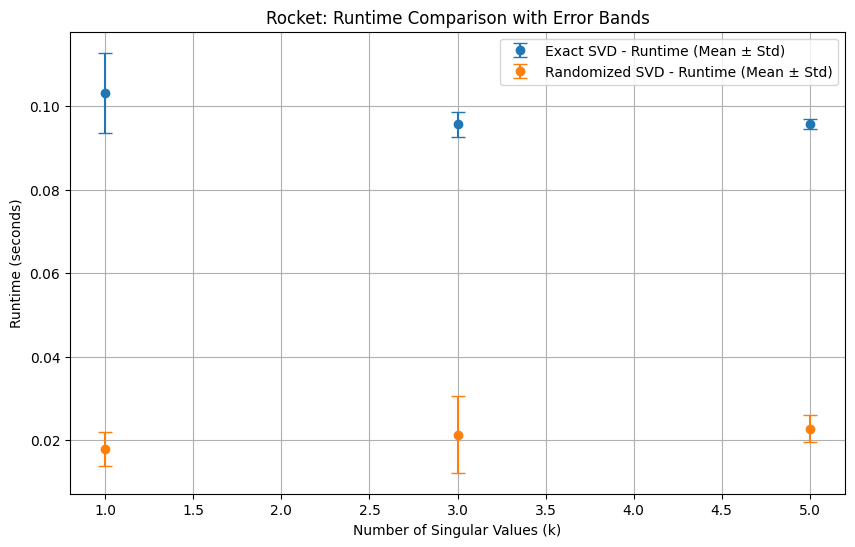

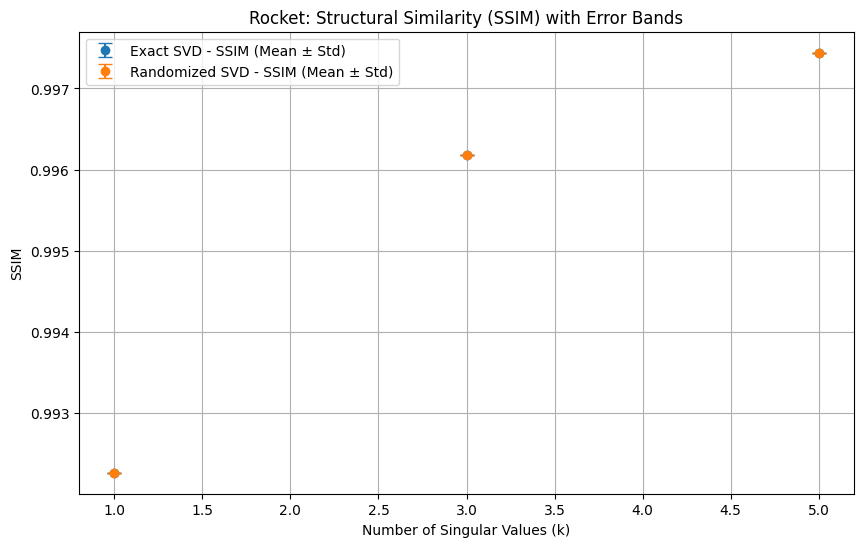

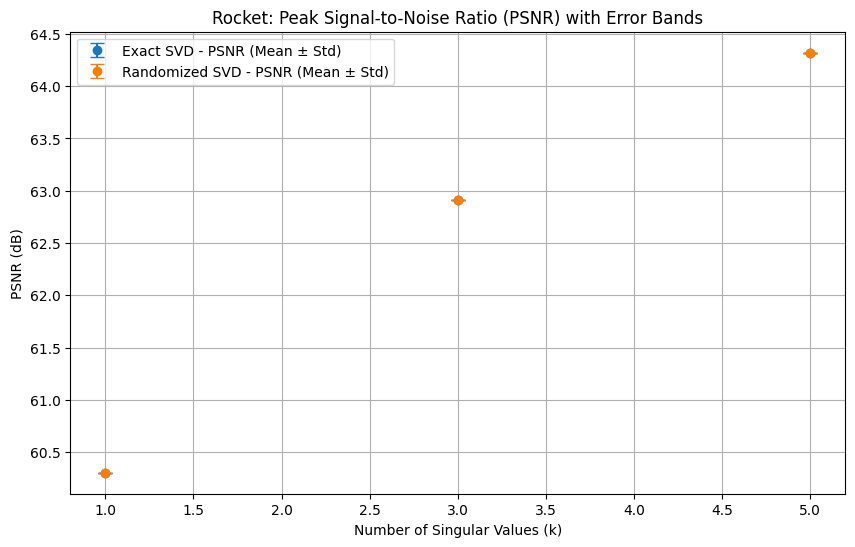

In [64]:
# Plot runtime with error bands

df = all[all["image"]=="Astronaut"]

plt.figure(figsize=(10, 6))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.errorbar(
        subset["k"],
        subset["mean_runtime"],
        yerr=subset["std_runtime"],
        label=f"{method} - Runtime (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("Runtime (seconds)")
plt.title(f"{image_name}: Runtime Comparison with Error Bands")
plt.legend()
plt.grid()
plt.show()

# Plot SSIM with error bands
plt.figure(figsize=(10, 6))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.errorbar(
        subset["k"],
        subset["mean_ssim"],
        yerr=subset["std_ssim"],
        label=f"{method} - SSIM (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("SSIM")
plt.title(f"{image_name}: Structural Similarity (SSIM) with Error Bands")
plt.legend()
plt.grid()
plt.show()

# Plot PSNR with error bands
plt.figure(figsize=(10, 6))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.errorbar(
        subset["k"],
        subset["mean_psnr"],
        yerr=subset["std_psnr"],
        label=f"{method} - PSNR (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("PSNR (dB)")
plt.title(f"{image_name}: Peak Signal-to-Noise Ratio (PSNR) with Error Bands")
plt.legend()
plt.grid()
plt.show()
